# Problem 1: MCMC for Poisson-gamma model

Consider a model 
\begin{align*}
x_n &\sim \text{Poisson}(uv),\\
u &\sim \text{Gamma}(6, 1),\\
v &\sim \text{Gamma}(3, 3).
\end{align*}
where individual observations $x_n$ are conditionally independent of each other. Use MCMC to infer $p(u,v|\mathbf{x})$ for the set of observations $\mathbf{x}=[5, 3, 9, 13, 5, 3, 5, 1, 2, 7, 6, 5, 6, 7, 4]$

Solve the following tasks related to this model:

1. **Write down the joint log-probability** $\log p(\mathbf{x},u,v)$
2. **Derive a Gibbs sampler** for this model by providing the conditional distributions $p(u|v,\mathbf{x})$ and $p(v|u,\mathbf{x})$
3. **Implement the Gibbs sampler** you just derived
4. **Run both the Gibbs sampler and Metropolis sampler** (using the implementation provided in the lecture notebook, or some other) and inspect the results. Plot the marginal distributions and trace plots of $u$ and $v$ as well as a cross-plot of the posterior samples. Finally, report the mean and variance of $u$ and $v$.
5. **Compare Gibbs and Metropolis** in this task. Do you find the same posterior with both? Are there any differences?

In [1]:
#imports

import numpy as np
import numpy.random as npr
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sps
%matplotlib inline

## Part 1: log-likelihood of the model

The joint likelihood with this model is given by:

$$p(\mathbf{x}, u, v) = p(u|6,1)p(v|3,3) \prod_{n=1}^N p(x_n)$$

Taking the logarithm:

$$\log p(\mathbf{x},u,v) = \log p(u|6,1) + \log p(v|3,3) + \sum_{n=1}^{N}\log p(x_n)$$

Using the PDFs of the respective distributions:

$$ \log p(\mathbf{x},u,v) = 6 \log(1) - \log\left( \Gamma(6) \right) + (6 - 1)\log(u) - 1\cdot u + 3 \log(3) - \log\left( \Gamma(3) \right) + (3 - 1)\log(v) - 3\cdot v + \sum_{n=1}^N \left[ x_n \log(uv) - uv - \log(x_n!) \right]$$

$$ \log p(\mathbf{x},u,v) = -\log(120) + 5\log(u) - u + 3 \log(3) - \log(2) + 2\log(v) - 3v + \log(uv)\sum_{n=1}^N \left[ x_n \right] - \sum_{n=1}^N\left[ \log(x_n!)\right] - Nuv$$

In [2]:
# Sanity check

x = np.array([5, 3, 9, 13, 5, 3, 5, 1, 2, 7, 6, 5, 6, 7, 4])
N = len(x)

def log_fact(x):
    result = 0
    for i in range(2, x+1):
        result += np.log(i)
    return result
        
# params=[u, v]
def joint(x, params):
    N = len(x)
    log_fact_x = 0
    for x_n in x:
        log_fact_x += log_fact(x_n)
    return -np.log(120) + 5*np.log(params[0]) - params[0] + 3*np.log(3) - np.log(2) + 2*np.log(params[1]) - 3*params[1] + np.log(params[0]*params[1])*np.sum(x) - log_fact_x - N*params[0]*params[1]

test_u = 5
test_v = 6
test_params = [test_u, test_v]

test_pdf_x = np.sum(sps.poisson.logpmf(x, test_u*test_v))
ground_truth = sps.gamma.logpdf(test_u, 6, scale=1) + sps.gamma.logpdf(test_v, 3, scale=1/3) + test_pdf_x

test = joint(x, test_params)

print("Ground truth: ", ground_truth)
print("Implementation test: ", test)

Ground truth:  -280.2246090419246
Implementation test:  -280.2246090419246


## Part 2: Derivation of the conditionals

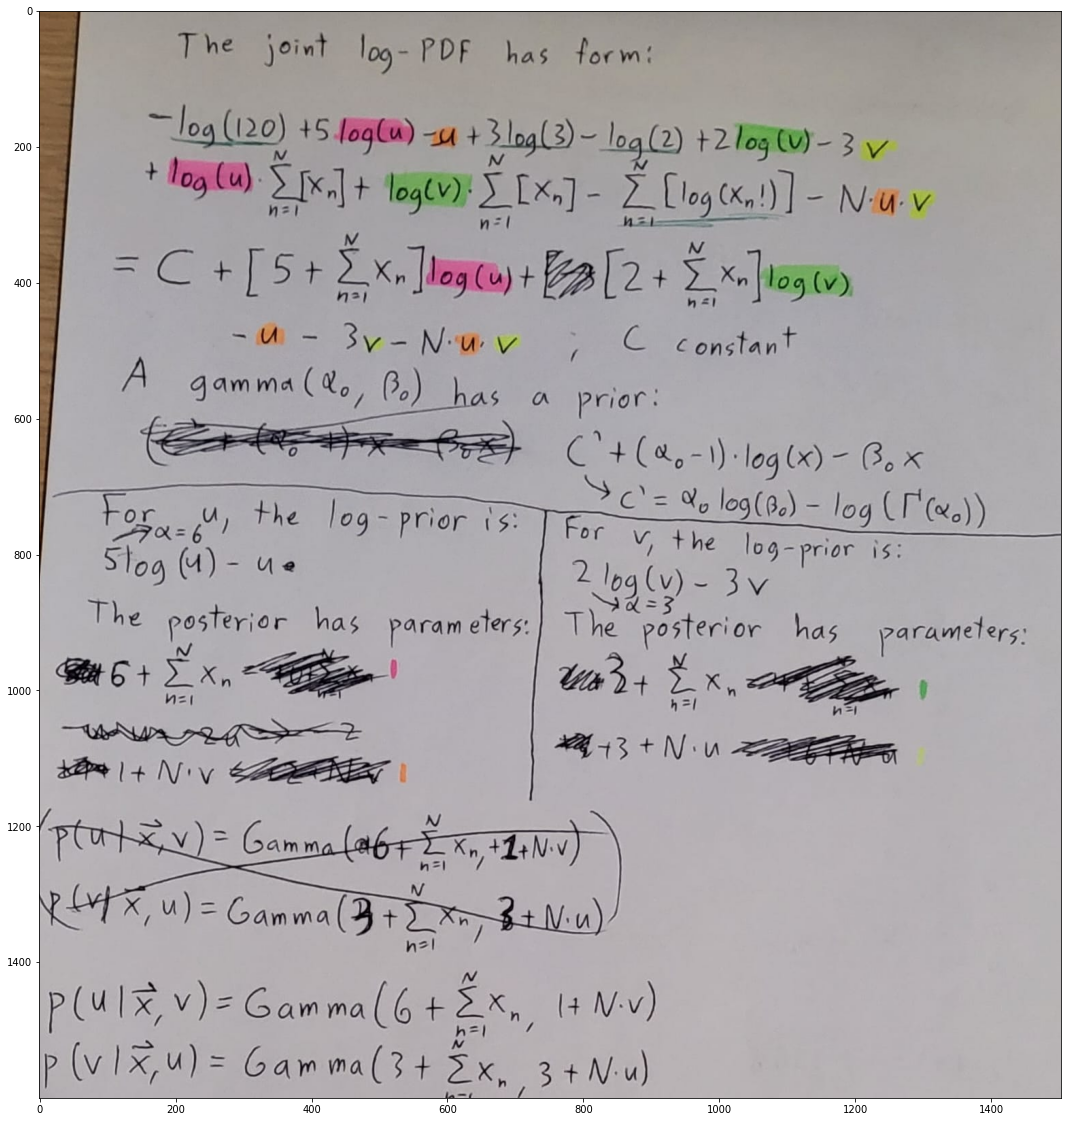

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('./posterior_derivation.jpeg')

plt.figure(figsize = (20,20))
plt.imshow(img)

## Definitions for sampling

In [4]:
np.random.seed(0)

x = np.array([5, 3, 9, 13, 5, 3, 5, 1, 2, 7, 6, 5, 6, 7, 4])

# Function for calculating the log of the factorial of a number
def log_fact(x):
    result = 0
    for i in range(2, x+1):
        result += np.log(i)
    return result

def log_density(x, params):
    # params=[u, v]
    
    N = len(x)
    log_fact_x = 0
    for x_n in x:
        log_fact_x += log_fact(x_n)
    return -np.log(120) + 5*np.log(params[0]) - params[0] + 3*np.log(3) - np.log(2) + 2*np.log(params[1]) - 3*params[1] + np.log(params[0]*params[1])*np.sum(x) - log_fact_x - N*params[0]*params[1]

prior_alpha_u = 6
prior_beta_u = 1
prior_alpha_v = 3
prior_beta_v = 3

# Define the actual prior using standard functions
u_prior = sps.gamma(prior_alpha_u, scale=1./prior_beta_u)
v_prior = sps.gamma(prior_alpha_v, scale=1./prior_beta_v)

n_samples = 5000

def sample_from_model(N, u_prior, v_prior):
    # Sample the values for the parameters
    u = u_prior.rvs(1)
    v = v_prior.rvs(1)
    # Sample data conditional on the parameters
    data = sps.poisson(u*v).rvs(N)
    return data, u, v

N = 10
x, u, v = sample_from_model(N, u_prior, v_prior)

matplotlib.rcParams['figure.figsize'] = [10, 10]

# Plotting the results of any sampler
def plotSamples(samples, warmup=500):
    plt.subplot(2,3,1)
    # Scatter plot of samples
    plt.plot(samples[:,0],samples[:,1], '.k', alpha=0.05)
    plt.plot(samples[:,0],samples[:,1], '-k', alpha=0.2)
    plt.title("Posterior samples")
    
    # Univariate histograms (ignoring warm-up)
    plt.subplot(2,3,2)
    plt.hist(samples[warmup:,0], bins=20)
    plt.hist(samples[warmup:,1], bins=20)
    plt.title("Marginals of the posterior")
    
    # Whole sampling chain
    plt.subplot(2,3,4)
    plt.plot(samples[:,0])
    plt.plot(samples[:,1])
    if(warmup>0):
        plt.axvline(x=warmup)
    plt.title("Sampling chain")
    
    # Zoomed-in sampling chain
    plt.subplot(2,3,5)
    plt.plot(samples[1000:1020,0])
    plt.plot(samples[1000:1020,1])
    plt.title("Sampling chain (zoomed in)")

    # Mean estimate
    plt.subplot(2,3,6)
    normalizer = np.arange(1,np.shape(samples)[0]+1-warmup)
    plt.plot(np.cumsum(samples[warmup:,0])/normalizer)
    plt.plot(np.cumsum(samples[warmup:,1])/normalizer)
    plt.title("Mean estimate")
    return

## Part 4: Metropolis

u
True: [10.99]
Expectation of the estimate: 8.07
Variance of the estimate: 4.91
v
True: [1.12]
Expectation of the estimate: 1.57
Variance of the estimate: 0.2


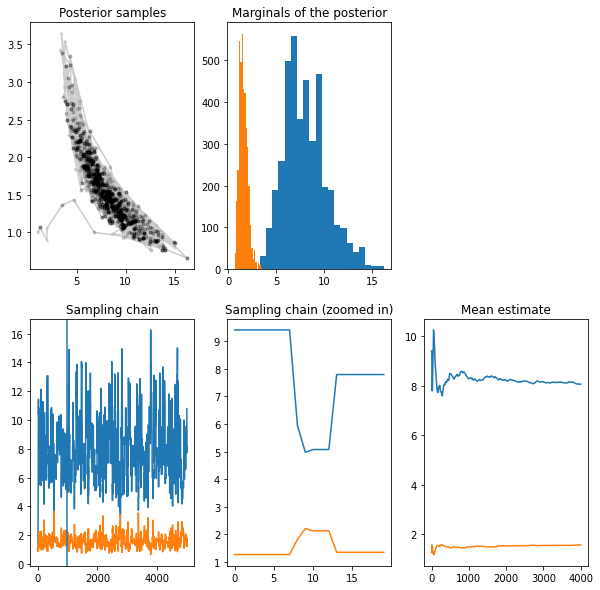

In [5]:
def Metropolis_sampler(log_density, x, param, T, prop_width=0.1, bounded=True):
    # If we have non-negative parameters then take log-transforms
    # 'bounded' is vector of indices to transform this way
    if bounded:
        param_unconstrained = param.copy()
        param_unconstrained[bounded] = np.log(param[bounded])
    # Storage for samples
    samples = param.copy()
    current_density = log_density(x, param)
    for t in range(T):
        # Propose a new sample
        if bounded:
            param_unconstrained_new = param_unconstrained + np.random.normal(0, prop_width, size=len(param))
            param_new = param_unconstrained_new.copy()
            param_new[bounded] = np.exp(param_unconstrained_new[bounded])
        else:
            param_new = param + np.random.normal(0, prop_width, size=len(param))
        new_density = log_density(x, param_new)
        # Accept according to the correct rule
        if(np.random.uniform(0.0,1.0) < np.exp(new_density - current_density)):
            param = param_new
            if bounded:
                param_unconstrained = param_unconstrained_new
            current_density = new_density
        samples = np.vstack([samples, param])
    return samples

mh_samples = Metropolis_sampler(log_density, x, np.array([1.0, 1.0]), n_samples, 0.4)

print("u")
print("True:", np.round(u,2))
print("Expectation of the estimate:", np.round(np.mean(mh_samples[n_samples//5:,0]), 2))
print("Variance of the estimate:", np.round(np.var(mh_samples[n_samples//5:,0]), 2))

print("v")
print("True:", np.round(v,2))
print("Expectation of the estimate:", np.round(np.mean(mh_samples[n_samples//5:,1]), 2))
print("Variance of the estimate:", np.round(np.var(mh_samples[n_samples//5:,1]), 2))

plotSamples(mh_samples, n_samples//5)

## Part 4: Gibbs

u
True: [10.99]
Expectation of the estimate: 7.96
Variance of the estimate: 4.78
v
True: [1.12]
Expectation of the estimate: 1.61
Variance of the estimate: 0.21


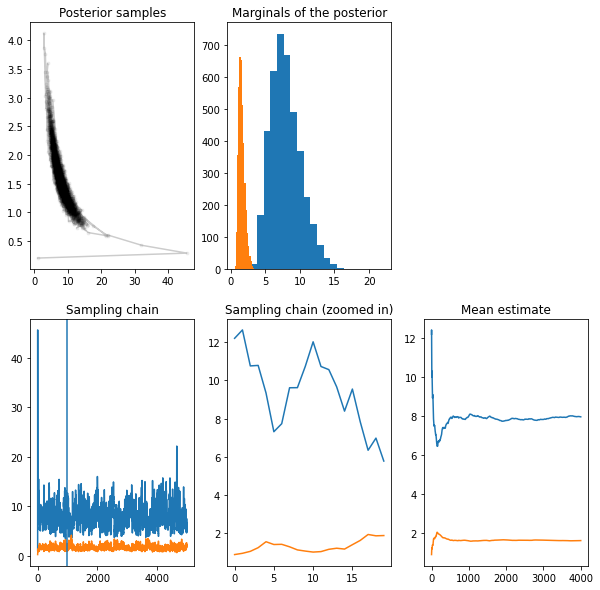

In [6]:
# # Before writing the Gibbs sampler you need pen-and-paper derivation of the conditionals

def Gibbs(log_density, x, param, T):
    # Storage for samples
    N = len(x)
    samples = param.copy()
    for t in range(T):
        # Sample u conditional on v
        param[0] = np.random.gamma(6 + np.sum(x), 1./(1+N*param[1]))

        # Storing the sample already after updating the mean allows better visualization of
        # what is going on, but is not useful in real use
        #samples = np.vstack([samples, param])
        
        # Sample v conditional on u
        param[1] = np.random.gamma(3 + np.sum(x), 1./(3 + N*param[0]))

        samples = np.vstack([samples, param])
    return samples

gibbs_samples = Gibbs(log_density, x, np.array([1.0, 0.2]), n_samples)

print("u")
print("True:", np.round(u,2))
print("Expectation of the estimate:", np.round(np.mean(gibbs_samples[n_samples//5:,0]),2))
print("Variance of the estimate:", np.round(np.var(gibbs_samples[n_samples//5:,0]), 2))

print("v")
print("True:", np.round(v,2))
print("Expectation of the estimate:", np.round(np.mean(gibbs_samples[n_samples//5:,1]),2))
print("Variance of the estimate:", np.round(np.var(gibbs_samples[n_samples//5:,1]), 2))

plotSamples(gibbs_samples, n_samples//5)

## Part 5: Comparison

# Problem 2: Latent Dirichlet Allocation
    
Start by getting familiar with the LDA model by reading the material provided in Moodle.

The code snippet below generates data from the model. Make sure you understand the dimensionalities and meanings of all terms, so that you can correctly manipulate them in the samplers. We will later use the data to try out the sammplers.

The data is intentionally very small so that you do not need to worry about code efficiency. If your code is fast, feel free to try it with larger $N$, $V$ and/or $L$.

In [7]:
import numpy as np
from scipy import stats

np.random.seed(789789)

# Define the data dimensionalities
N = 40   # Number of documents
V = 100  # Vocabulary size
L = 50   # Length of each document (here identical for simplicity)

# Hyperparameters
alpha_true = 0.1
gamma_true = 0.1
K_true = 10

# Sample data from the model
def create_data(N, V, K, L):
    # Topic distributions of individual documents
    pi = stats.dirichlet(alpha_true*np.ones(K)).rvs(N)
    # Word distributions of individual topics
    b = stats.dirichlet(gamma_true*np.ones(V)).rvs(K_true)
    q = np.zeros((N, L), 'int')
    y = np.zeros((N, L), 'int')
    for n in range(N):
        for w in range(L):
            # Sample topic responsible for generating the word
            topic = np.random.choice(K_true, 1, p=pi[n,:])[0]
            q[n, w] = topic
            # Sample the word itself
            word = np.random.choice(V, 1, p=b[topic,:])[0]
            y[n, w] = word
    return y, pi, b, q

y, pi_true, b_true, q_true = create_data(N, V, K_true, L)

## (a) Direct Gibbs

Implement a direct Gibbs sampler, following Equations (27.30) - (27.32) that give the conditional distributions needed for sampling $\pi$ and $q_{il}$ (the responsible topic for each word) and $b_k$ (the topics). Note that here the book suddenly uses $x_{il}$ instead of $y_{il}$ -- this is a mistake in the book. 

For initialization (of both samplers) you can sample $\pi$ and $b$ from their priors and then use Equation (27.30) to get initial $q$.

In [8]:
# You will probably want to write a separate function for each conditional distribution

# You will also need a function that computes the $c_{ivk}$ based on $q_{il}$.
# Pay attention to the indexing; in $c_{ivk}$ the index $v$ is the word identity,
# which is *not* the same thing as $l$ that gives the running index of each word. 

# ...and then a simple loop for the main algorithm that uses the functions above

## (b) Collapsed Gibbs

Implement a collapsed Gibbs sampler. For this you will need the Equation (27.37) that provides the probabilities for sampling $q_{il}$ for one word conditional on the allocations for all others, integrating over $\pi$ and $b$. Note that you can still use equations (27.31) and (27.32) to obtain $\pi$ and $b$ for interpretation after running the algorithm.

Collapsed Gibbs is easiest to implement by storing and updating both $c_{ivk}$ and $q_{il}$. To allocate a new sample you first subtract one from $c_{ivk}$ based on current value $q_{il}$ before computing all the sums for equation (27.37). After sampling a new value you add one to the right element and update the corresponding element in $q_{il}$. This is inefficient compared to explicitly maintaining also the different marginal sums, but does not matter for our small data.

In [9]:
# Implement here the collapsed sampler

# (c) Evaluate the samplers

Run both samplers on the toy data and study the results. You can use the same $\alpha$, $\gamma$ and $K$ that were used when creating the data.

1. Plot the "document-to-topic" and "topic-to-word" distributions for the last posterior sample and compare them against the true values used when generating the data. Note that LDA is not permutation-invariant -- there is no reason to expect the topics would appear in the same order in your solution as in the generation process. To better compare them, you can sort the topics according to their overall popularity.

2. Investigate a single document to understand how the model works. Check that the document is using topics that have high probability of generating the words that appear in the document. Try to be 'properly Bayesian' here, in the sense that you do not look only at the last posterior sample but attempt to characterise also the variation in some way.

3. Would you prefer the direct or collapsed sampler? Was one of them easier to implement? Do you think one works better?

